In [2]:
import re
from collections import Counter
import os # For checking file existence

# Third-party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [5]:
df = pd.read_csv("ner.csv", encoding="ISO-8859-1", on_bad_lines='skip')
print("Shape of the raw dataframe:", df.shape)
print("First 5 rows of the dataframe:\n", df.head())
print("\nColumns in the dataframe:", df.columns)
print("\nInfo about the dataframe:")
df.info()

Shape of the raw dataframe: (190891, 25)
First 5 rows of the dataframe:
    Unnamed: 0     lemma next-lemma next-next-lemma next-next-pos  \
0           0  thousand         of        demonstr           NNS   
1           1        of   demonstr            have           VBP   
2           2  demonstr       have           march           VBN   
3           3      have      march         through            IN   
4           4     march    through          london           NNP   

  next-next-shape next-next-word next-pos next-shape      next-word  ...  \
0       lowercase  demonstrators       IN  lowercase             of  ...   
1       lowercase           have      NNS  lowercase  demonstrators  ...   
2       lowercase        marched      VBP  lowercase           have  ...   
3       lowercase        through      VBN  lowercase        marched  ...   
4     capitalized         London       IN  lowercase        through  ...   

  prev-prev-lemma prev-prev-pos prev-prev-shape prev-prev-wor

In [6]:
if 'sentence_idx' in df.columns:
    print(f"\nNumber of sentences (based on sentence_idx): {df['sentence_idx'].nunique()}")
    print(f"NaNs in 'sentence_idx': {df['sentence_idx'].isnull().sum()}")
else:
    print("\n'sentence_idx' column not found. This column is crucial for grouping words into sentences.")
    print("Please ensure your CSV has a column that identifies sentences (e.g., 'Sentence #', 'sentence_idx').")
    # Attempt to infer sentence_idx if a common alternative exists
    if 'Sentence #' in df.columns:
        print("Found 'Sentence #'. Renaming to 'sentence_idx'.")
        df.rename(columns={'Sentence #': 'sentence_idx'}, inplace=True)
    else:
        exit()


Number of sentences (based on sentence_idx): 8743
NaNs in 'sentence_idx': 1


In [7]:
df['sentence_idx'] = df['sentence_idx'].ffill()

In [8]:
sentences_words = []
sentences_tags = []

# Check if 'word' and 'tag' columns exist
if 'word' not in df.columns or 'tag' not in df.columns:
    print("Error: 'word' or 'tag' column not found in the DataFrame.")
    print("Please ensure your CSV has columns for words and their corresponding NER tags.")
    exit()

# Drop rows where 'word' is NaN, as they are not useful
df_cleaned = df.dropna(subset=['word'])

# Ensure 'tag' is also present; fill NaN tags with 'O' (Outside) as a common practice
df_cleaned['tag'] = df_cleaned['tag'].fillna('O')


grouped = df_cleaned.groupby("sentence_idx")
for _, group in tqdm(grouped, desc="Grouping sentences"):
    words = group["word"].tolist()
    tags = group["tag"].tolist()
    if len(words) > 0: # Ensure sentence is not empty
        sentences_words.append(words)
        sentences_tags.append(tags)

print(f"\nNumber of sentences after grouping: {len(sentences_words)}")
if sentences_words:
    print("Sample sentence (words):", sentences_words[0][:15])
    print("Sample tags (labels):", sentences_tags[0][:15])
else:
    print("No sentences were processed. Check the 'sentence_idx' column and data integrity.")
    exit()

<ipython-input-8-f2ae4d511fda>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['tag'] = df_cleaned['tag'].fillna('O')


Grouping sentences:   0%|          | 0/8743 [00:00<?, ?it/s]


Number of sentences after grouping: 8743
Sample sentence (words): ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand']
Sample tags (labels): ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O']


In [9]:
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    sentences_words, sentences_tags, test_size=0.3, random_state=42 # 70% train, 30% temp
)

# Split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42 # 0.5 of 0.3 = 15% val, 15% test
)

print(f"\nData Splitting:")
print(f"Number of training samples: {len(X_train_full)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of test samples: {len(X_test)}")
if X_train_full:
    print("Sample training sentence (words):", X_train_full[0][:15])
    print("Sample training tags (labels):", y_train_full[0][:15])


Data Splitting:
Number of training samples: 6120
Number of validation samples: 1311
Number of test samples: 1312
Sample training sentence (words): ['Police', 'said', 'he', 'appeared', 'to', 'have', 'been', 'strangled', 'with', 'a', 'belt', 'and', 'had', 'multiple', 'stab']
Sample training tags (labels): ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [10]:
def clean_and_normalize_word(word):
    """Clean and normalize a single word."""
    word_str = str(word).lower().strip()
    return word_str

def preprocess_sentence_data(sentences_words_list, sentences_tags_list):
    processed_sentences = []
    processed_tags = []
    skipped_count = 0
    for words, tags in tqdm(zip(sentences_words_list, sentences_tags_list), total=len(sentences_words_list), desc="Preprocessing sentences"):
        # Ensure words are strings before cleaning, handle potential float NaNs if any survived
        cleaned_words = [clean_and_normalize_word(w) for w in words if pd.notna(w)]

        if len(cleaned_words) == len(tags) and len(cleaned_words) > 0:
            processed_sentences.append(cleaned_words)
            processed_tags.append(tags)
        elif len(cleaned_words) > 0 :
            skipped_count += 1
        elif len(cleaned_words) == 0 and len(words) > 0:
            skipped_count += 1
    if skipped_count > 0:
        print(f"Skipped {skipped_count} sentences due to length mismatches or empty results after cleaning.")
    return processed_sentences, processed_tags

print("\nPreprocessing Training Data...")
X_train, y_train = preprocess_sentence_data(X_train_full, y_train_full)
print("\nPreprocessing Validation Data...")
X_val, y_val = preprocess_sentence_data(X_val, y_val)
print("\nPreprocessing Test Data...")
X_test, y_test = preprocess_sentence_data(X_test, y_test)

print(f"\nNumber of training samples after cleaning: {len(X_train)}")
print(f"Number of validation samples after cleaning: {len(X_val)}")
print(f"Number of test samples after cleaning: {len(X_test)}")

if not X_train or not X_val or not X_test:
    print("Warning: One or more data splits are empty after preprocessing. This can happen if many sentences were skipped.")
    print("Review the cleaning function and data quality. Exiting to prevent further errors.")
    exit()


if X_train:
    print(f"\nSample preprocessed training sentence: {X_train[0][:15]}")
    print(f"Sample preprocessed training tags: {y_train[0][:15]}")
else:
    print("No training data available after preprocessing. Check cleaning steps and data.")
    exit()


Preprocessing Training Data...


Preprocessing sentences:   0%|          | 0/6120 [00:00<?, ?it/s]


Preprocessing Validation Data...


Preprocessing sentences:   0%|          | 0/1311 [00:00<?, ?it/s]


Preprocessing Test Data...


Preprocessing sentences:   0%|          | 0/1312 [00:00<?, ?it/s]


Number of training samples after cleaning: 6120
Number of validation samples after cleaning: 1311
Number of test samples after cleaning: 1312

Sample preprocessed training sentence: ['police', 'said', 'he', 'appeared', 'to', 'have', 'been', 'strangled', 'with', 'a', 'belt', 'and', 'had', 'multiple', 'stab']
Sample preprocessed training tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [11]:
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
TAG_FOR_PADDING_REPRESENTATION = "O"


def build_word_vocab(all_sentences, min_freq=1):
    word_counts = Counter(word for sentence in all_sentences for word in sentence if word) # Ensure word is not empty
    vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    idx = 2
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

def build_tag_vocab(all_tags_lists, pad_tag_representation="O"):
    """
    Builds a tag vocabulary ensuring the padding tag is at index 0.
    """
    tag_counts = Counter(tag for tag_list in all_tags_lists for tag in tag_list)
    unique_tags = sorted(tag_counts.keys())

    tag_to_idx = {pad_tag_representation: 0}
    idx = 1
    for tag in unique_tags:
        if tag != pad_tag_representation:
             tag_to_idx[tag] = idx
             idx +=1

    idx_to_tag = {i: t for t, i in tag_to_idx.items()}
    return tag_to_idx, idx_to_tag

In [13]:
word_vocab = build_word_vocab(X_train)
all_y_tags_for_vocab = y_train + y_val + y_test
tag_vocab_map, idx_to_tag_map = build_tag_vocab(all_y_tags_for_vocab, TAG_FOR_PADDING_REPRESENTATION)

TAG_PAD_IDX = tag_vocab_map[TAG_FOR_PADDING_REPRESENTATION] # This must be 0 based on build_tag_vocab
MAX_LEN = 75
print(f"Word vocabulary size: {len(word_vocab)}")
print(f"Tag vocabulary size: {len(tag_vocab_map)}")
print(f"Sample word vocab (first 10): {list(word_vocab.items())[:10]}")
print(f"Tag to index mapping: {tag_vocab_map}")
print(f"Index for padding tag ('{TAG_FOR_PADDING_REPRESENTATION}'): {TAG_PAD_IDX}")

if TAG_PAD_IDX != 0:
    print(f"CRITICAL WARNING: TAG_PAD_IDX is {TAG_PAD_IDX}, but it should be 0 for CrossEntropyLoss ignore_index. Check build_tag_vocab logic.")

Word vocabulary size: 11920
Tag vocabulary size: 17
Sample word vocab (first 10): [('<PAD>', 0), ('<UNK>', 1), ('police', 2), ('said', 3), ('he', 4), ('appeared', 5), ('to', 6), ('have', 7), ('been', 8), ('strangled', 9)]
Tag to index mapping: {'O': 0, 'B-art': 1, 'B-eve': 2, 'B-geo': 3, 'B-gpe': 4, 'B-nat': 5, 'B-org': 6, 'B-per': 7, 'B-tim': 8, 'I-art': 9, 'I-eve': 10, 'I-geo': 11, 'I-gpe': 12, 'I-nat': 13, 'I-org': 14, 'I-per': 15, 'I-tim': 16}
Index for padding tag ('O'): 0


In [14]:
class NERDataset(Dataset):
    def __init__(self, sentences_words, sentences_tags, word_vocab, tag_vocab_map, max_len,
                 pad_token="<PAD>", unk_token="<UNK>", tag_for_padding_representation="O"):
        self.sentences_words = sentences_words
        self.sentences_tags = sentences_tags
        self.word_vocab = word_vocab
        self.tag_vocab_map = tag_vocab_map
        self.max_len = max_len

        self.unk_idx = word_vocab[unk_token]
        self.word_pad_idx = word_vocab[pad_token]
        self.tag_pad_idx = tag_vocab_map[tag_for_padding_representation] # Should be 0

    def __len__(self):
        return len(self.sentences_words)

    def __getitem__(self, idx):
        words = self.sentences_words[idx]
        tags = self.sentences_tags[idx]

        word_indices = [self.word_vocab.get(w, self.unk_idx) for w in words]
        o_tag_idx_for_unknown = self.tag_vocab_map.get('O', self.tag_pad_idx)
        tag_indices = [self.tag_vocab_map.get(t, o_tag_idx_for_unknown) for t in tags]
        if len(word_indices) >= self.max_len:
            padded_word_indices = word_indices[:self.max_len]
        else:
            padded_word_indices = word_indices + [self.word_pad_idx] * (self.max_len - len(word_indices))

        # Pad/truncate sequences for tags
        if len(tag_indices) >= self.max_len:
            padded_tag_indices = tag_indices[:self.max_len]
        else:
            padded_tag_indices = tag_indices + [self.tag_pad_idx] * (self.max_len - len(tag_indices))

        return torch.tensor(padded_word_indices, dtype=torch.long), \
               torch.tensor(padded_tag_indices, dtype=torch.long)

In [15]:
train_dataset = NERDataset(X_train, y_train, word_vocab, tag_vocab_map, MAX_LEN,
                           pad_token=PAD_TOKEN, unk_token=UNK_TOKEN,
                           tag_for_padding_representation=TAG_FOR_PADDING_REPRESENTATION)
val_dataset = NERDataset(X_val, y_val, word_vocab, tag_vocab_map, MAX_LEN,
                         pad_token=PAD_TOKEN, unk_token=UNK_TOKEN,
                         tag_for_padding_representation=TAG_FOR_PADDING_REPRESENTATION)
test_dataset = NERDataset(X_test, y_test, word_vocab, tag_vocab_map, MAX_LEN,
                          pad_token=PAD_TOKEN, unk_token=UNK_TOKEN,
                          tag_for_padding_representation=TAG_FOR_PADDING_REPRESENTATION)

print(f"\nNumber of items in train_dataset: {len(train_dataset)}")
if len(train_dataset) > 0:
    sample_words_tensor, sample_tags_tensor = train_dataset[0]
    print(f"Sample input tensor shape: {sample_words_tensor.shape}")
    print(f"Sample label tensor shape: {sample_tags_tensor.shape}")
    print(f"Sample input tensor (first 15): {sample_words_tensor[:15]}")
    print(f"Sample label tensor (first 15): {sample_tags_tensor[:15]}")
else:
    print("Train dataset is empty. Cannot proceed.")
    exit()


Number of items in train_dataset: 6120
Sample input tensor shape: torch.Size([75])
Sample label tensor shape: torch.Size([75])
Sample input tensor (first 15): tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])
Sample label tensor (first 15): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [16]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created.")
print(f"Number of batches in train_loader: {len(train_loader)}")
if len(train_loader) > 0:

    sample_batch_words, sample_batch_tags = next(iter(train_loader))
    print(f"Sample batch words shape: {sample_batch_words.shape}")
    print(f"Sample batch tags shape: {sample_batch_tags.shape}")
else:
    print("Train loader is empty. Cannot proceed with training.")
    exit()


DataLoaders created.
Number of batches in train_loader: 192
Sample batch words shape: torch.Size([32, 75])
Sample batch tags shape: torch.Size([32, 75])


In [17]:
class NERLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size,
                 n_layers=1, dropout_prob=0.5, bidirectional=True,
                 word_pad_idx=0):
        super(NERLSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.tagset_size = tagset_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word_pad_idx)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True,
                            dropout=dropout_prob if n_layers > 1 else 0)

        self.dropout_layer = nn.Dropout(dropout_prob)
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, tagset_size)

    def forward(self, text_sequences):
        embedded = self.embedding(text_sequences)

        lstm_out, _ = self.lstm(embedded)

        lstm_out = self.dropout_layer(lstm_out)

        logits = self.fc(lstm_out)
        return logits

In [19]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
N_LAYERS = 2
DROPOUT_PROB = 0.33
BIDIRECTIONAL = True
VOCAB_SIZE = len(word_vocab)
TAGSET_SIZE = len(tag_vocab_map)
WORD_PAD_IDX = word_vocab[PAD_TOKEN]


# Initialize the model
ner_model = NERLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, TAGSET_SIZE,
                    N_LAYERS, DROPOUT_PROB, BIDIRECTIONAL, WORD_PAD_IDX)
ner_model.to('cpu')

print("\nNER Model initialized:")
print(ner_model)

# Sanity check with a dummy batch
if len(train_loader) > 0:
    dummy_batch_words, _ = next(iter(train_loader))
    dummy_batch_words = dummy_batch_words.to('cpu')
    with torch.no_grad():
        ner_model.eval() # Set to eval mode for sanity check
        predictions = ner_model(dummy_batch_words)
    print(f"Output shape of the model for a dummy batch: {predictions.shape}") # Expected: [BATCH_SIZE, MAX_LEN, TAGSET_SIZE]
else:
    print("Cannot perform model sanity check as train_loader is empty.")


NER Model initialized:
NERLSTM(
  (embedding): Embedding(11920, 100, padding_idx=0)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.33, bidirectional=True)
  (dropout_layer): Dropout(p=0.33, inplace=False)
  (fc): Linear(in_features=512, out_features=17, bias=True)
)
Output shape of the model for a dummy batch: torch.Size([32, 75, 17])


In [20]:
criterion = nn.CrossEntropyLoss(ignore_index=TAG_PAD_IDX)
optimizer = optim.Adam(ner_model.parameters(), lr=0.001)

Loss function: CrossEntropyLoss (ignoring index 0 which corresponds to tag 'O')
Optimizer: Adam


In [21]:
def calculate_accuracy(preds_logits, y_true, pad_idx_in_true_labels):
    max_preds_indices = preds_logits.argmax(dim=2)
    non_pad_elements_mask = (y_true != pad_idx_in_true_labels)
    correct_predictions = (max_preds_indices == y_true).float()
    num_correct_non_pad = (correct_predictions * non_pad_elements_mask).sum()
    num_non_pad_actual = non_pad_elements_mask.sum()

    accuracy = num_correct_non_pad / num_non_pad_actual if num_non_pad_actual > 0 else 0.0
    return accuracy


In [22]:
def train_epoch(model, iterator, optimizer, criterion, device, tag_pad_idx_for_loss):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch_idx, (text_sequences, true_tags_indices) in enumerate(tqdm(iterator, desc="Training", leave=False)):
        text_sequences = text_sequences.to(device)
        true_tags_indices = true_tags_indices.to(device)

        optimizer.zero_grad()
        predictions_logits = model(text_sequences)
        predictions_reshaped = predictions_logits.view(-1, predictions_logits.shape[-1])
        true_tags_reshaped = true_tags_indices.view(-1)

        loss = criterion(predictions_reshaped, true_tags_reshaped)
        acc = calculate_accuracy(predictions_logits, true_tags_indices, tag_pad_idx_for_loss)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def evaluate_epoch(model, iterator, criterion, device, tag_pad_idx_for_eval):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch_idx, (text_sequences, true_tags_indices) in enumerate(tqdm(iterator, desc="Evaluating", leave=False)):
            text_sequences = text_sequences.to(device)
            true_tags_indices = true_tags_indices.to(device)

            predictions_logits = model(text_sequences)

            predictions_reshaped = predictions_logits.view(-1, predictions_logits.shape[-1])
            true_tags_reshaped = true_tags_indices.view(-1)

            loss = criterion(predictions_reshaped, true_tags_reshaped)
            acc = calculate_accuracy(predictions_logits, true_tags_indices, tag_pad_idx_for_eval)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
N_EPOCHS = 10

train_losses, train_accs = [], []
val_losses, val_accs = [], []

best_val_loss = float('inf')
model_save_path = 'ner_lstm_model_best.pt'

print(f"\nStarting training for {N_EPOCHS} epochs on {'cpu'}...")
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_epoch(ner_model, train_loader, optimizer, criterion, 'cpu', TAG_PAD_IDX)
    val_loss, val_acc = evaluate_epoch(ner_model, val_loader, criterion, 'cpu', TAG_PAD_IDX)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1:02}/{N_EPOCHS}")
    print(f"\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {val_loss:.4f} |  Val. Acc: {val_acc*100:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': ner_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
            'word_vocab': word_vocab,
            'tag_vocab_map': tag_vocab_map,
            'idx_to_tag_map': idx_to_tag_map, # Save this for easy tag lookup later
            'max_len': MAX_LEN,
            'embedding_dim': EMBEDDING_DIM,
            'hidden_dim': HIDDEN_DIM,
            'n_layers': ner_model.n_layers,
            'dropout_prob': ner_model.dropout_layer.p, # Access dropout prob from the layer
            'bidirectional': ner_model.bidirectional,
            'word_pad_idx': WORD_PAD_IDX,
            'tag_pad_idx': TAG_PAD_IDX, # Index used for padding in tags
            'tag_for_padding_representation': TAG_FOR_PADDING_REPRESENTATION # Actual tag string for padding
        }, model_save_path)
        print(f"\t -> New best validation loss: {val_loss:.4f}. Model saved to {model_save_path}")


print("\nTraining complete!")


Starting training for 10 epochs on cpu...


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 01/10
	Train Loss: 1.4616 | Train Acc: 52.23%
	 Val. Loss: 0.9627 |  Val. Acc: 70.10%
	 -> New best validation loss: 0.9627. Model saved to ner_lstm_model_best.pt


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 02/10
	Train Loss: 0.7937 | Train Acc: 75.25%
	 Val. Loss: 0.7574 |  Val. Acc: 76.35%
	 -> New best validation loss: 0.7574. Model saved to ner_lstm_model_best.pt


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 03/10
	Train Loss: 0.5544 | Train Acc: 82.26%
	 Val. Loss: 0.7119 |  Val. Acc: 78.12%
	 -> New best validation loss: 0.7119. Model saved to ner_lstm_model_best.pt


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 04/10
	Train Loss: 0.3823 | Train Acc: 87.67%
	 Val. Loss: 0.7401 |  Val. Acc: 77.44%


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 05/10
	Train Loss: 0.2470 | Train Acc: 92.04%
	 Val. Loss: 0.8268 |  Val. Acc: 77.26%


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 06/10
	Train Loss: 0.1568 | Train Acc: 95.04%
	 Val. Loss: 0.9383 |  Val. Acc: 76.74%


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 07/10
	Train Loss: 0.1048 | Train Acc: 96.59%
	 Val. Loss: 1.0150 |  Val. Acc: 77.05%


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 08/10
	Train Loss: 0.0652 | Train Acc: 97.97%
	 Val. Loss: 1.1501 |  Val. Acc: 76.42%


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 09/10
	Train Loss: 0.0405 | Train Acc: 98.82%
	 Val. Loss: 1.2026 |  Val. Acc: 77.00%


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 10/10
	Train Loss: 0.0304 | Train Acc: 99.08%
	 Val. Loss: 1.2553 |  Val. Acc: 77.49%

Training complete!


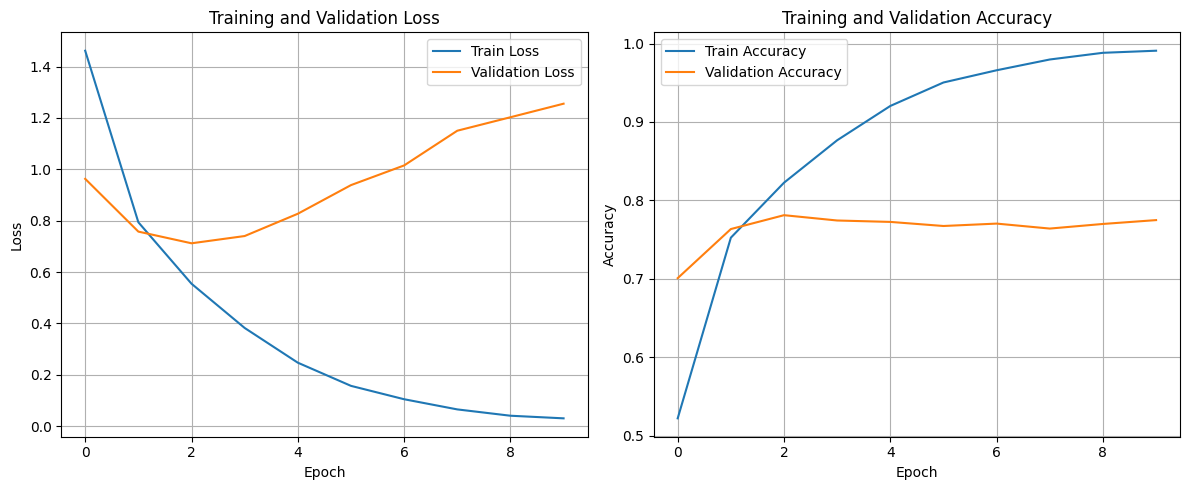

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
if os.path.exists(model_save_path):
    checkpoint = torch.load(model_save_path, map_location='cpu')

    # Re-initialize model with saved parameters
    loaded_model_arch = NERLSTM(
        vocab_size=len(checkpoint['word_vocab']),
        embedding_dim=checkpoint['embedding_dim'],
        hidden_dim=checkpoint['hidden_dim'],
        tagset_size=len(checkpoint['tag_vocab_map']),
        n_layers=checkpoint['n_layers'],
        dropout_prob=checkpoint['dropout_prob'],
        bidirectional=checkpoint['bidirectional'],
        word_pad_idx=checkpoint['word_pad_idx']
    )
    loaded_model_arch.load_state_dict(checkpoint['model_state_dict'])
    loaded_model_arch.to('cpu')
test_loss, test_acc = evaluate_epoch(loaded_model_arch, test_loader, criterion, 'cpu', checkpoint['tag_pad_idx'])
print(f"\nTest Set Performance (using best saved model):")
print(f"\tTest Loss: {test_loss:.4f}")
print(f"\tTest Acc: {test_acc*100:.2f}%")

Evaluating:   0%|          | 0/41 [00:00<?, ?it/s]


Test Set Performance (using best saved model):
	Test Loss: 0.7359
	Test Acc: 77.31%
